In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import glob
import re
import cftime
import datetime
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap, Normalize
import matplotlib.patches as patches
import matplotlib as mpl

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cartopy.mpl.ticker as cticker
import cartopy as cart
#import imageio
import scipy.stats as stats
#import pingouin as pg
import random
import calendar

from CE_Functions import *
from ClimateModesForCEs import *
from PlottingForCEs import *

mpl.rcParams['figure.dpi'] = 300

Data Preprocessing

In [2]:
# Regridded ERA5 Data
era5 = xr.open_dataset('/Users/aedwyer/Documents/CESM_data/Regridded_ERA5.nc')
expver1 = era5.sel(expver = 1)
lat = era5['lat']
lon = era5['lon']

## CALL IN MODES ##

# Calling in the ENSO indices, using the file of ENSO indices that we used in Climate
# Values from January 1950 to January 2024
nino_34_file_path = '/Users/aedwyer/Documents/Classes/Climate/detrend.nino34.ascii.txt'
nino_34 = pd.read_csv(nino_34_file_path, delim_whitespace=True)
nino_34_anoms = nino_34['ANOM'].values

# Calling in PDO and then revamping the file. 
pdo_file_path = '/Users/aedwyer/Documents/CESM_data/Climate_Mode_Indices/monthly_pdo_indices.txt'
pdo_indices = pd.read_csv(pdo_file_path, delim_whitespace=True, skiprows = 1)
pdo_indices.columns = ['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
# pull out the anomalies for the hadCRUT5 file and drop the other rows
pdo_melted = pdo_indices.melt(id_vars=['Year'], var_name='Month', value_name='Anomaly')
# switch the months to numbers so readabaility between nino indices and hadcrut5 indices are easier
month_to_num = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
                'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
pdo_melted['Month'] = pdo_melted['Month'].map(month_to_num)
pdo_sorted = pdo_melted.sort_values(by=['Year', 'Month']).reset_index(drop=True)
pdo_anoms = pdo_sorted['Anomaly'].values
pdo_anoms_1950_2024 = pdo_anoms[1152:2040]

nao_file_path = '/Users/aedwyer/Documents/CESM_data/Climate_Mode_Indices/nao_station_monthly.txt'
nao_indices = pd.read_csv(nao_file_path, delim_whitespace = True, header =1)
nao_indices.insert(0, 'Index', nao_indices.index)
nao_indices.columns = ['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
# pull out the anomalies for the hadCRUT5 file and drop the other rows
nao_melted = nao_indices.melt(id_vars=['Year'], var_name='Month', value_name='Anomaly')
# switch the months to numbers so readabaility between nino indices and hadcrut5 indices are easier
month_to_num = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
                'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
nao_melted['Month'] = nao_melted['Month'].map(month_to_num)
nao_sorted = nao_melted.sort_values(by=['Year', 'Month']).reset_index(drop=True)
nao_anoms = nao_sorted['Anomaly'].values
nao_anoms_1950_2023 = nao_anoms[1020:-12]


iod_file_path = '/Users/aedwyer/Documents/CESM_data/Climate_Mode_Indices/IOD_indices.txt'
with open(iod_file_path, 'r') as file:
    total_lines = sum(1 for line in file)
iod_indices = pd.read_csv(iod_file_path, delim_whitespace=True, skiprows = 1, nrows = total_lines - 10 )
iod_indices.columns = ['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
iod_melted = iod_indices.melt(id_vars=['Year'], var_name='Month', value_name='Anomaly')
iod_melted['Month'] = iod_melted['Month'].map(month_to_num)
iod_sorted = iod_melted.sort_values(by = ['Year', 'Month']).reset_index(drop=True)
iod_anoms = iod_sorted['Anomaly'].values
iod_anoms_1950_2024 = iod_anoms[948:]


## CALCULATE PRECIP RATE FROM ERA5 DATA ##
# Calculate the number of seconds in each month
# precipitation is already m/day not just m, so just need to divide by the s in a day not the actual month, I am going to keep the rest though in a comment just in case.
seconds_per_month = []

for year in range(1940, 2024):  
    for month in range(1, 13):
        days_in_month = calendar.monthrange(year, month)[1]
        seconds_in_month = 24 * 60 * 60 # * days_in_month
        seconds_per_month.append(seconds_in_month)

# Create a DataArray for seconds per month
seconds_per_month_da = xr.DataArray(seconds_per_month, dims=('time',), coords={'time': era5['time'][:1008]})

total_precip_rate = expver1['tp'][:1008] / seconds_per_month_da  # Seconds in a month
total_precip_rate = total_precip_rate[:1008]
temps = expver1['t2m'][:1008] - 273.15

surface_temps = expver1['skt'][:1008] - 273.15

## DETREND ERA5 DATA USING THIRD ORDER POLYNOMIALS ##
# Group Temperatures into months
month_indices_temps = temps.groupby('time.month')

# Create the list that will hold the temperatures once they are detrended
temps_detrended_list = []
fit_list = []
for i in range(1,13):
    # fit the third order polynomial
    line_fit = month_indices_temps[i].polyfit('time', 3)
    fit = xr.polyval(month_indices_temps[i].time, line_fit.polyfit_coefficients)
    fit_list.append(fit)
    # subtract the polynomial from the actual data
    temps_detrended = month_indices_temps[i] - fit

    # Append to the list
    temps_detrended_list.append(temps_detrended)

# create xarray to that of the temperatures to store all the values
detrended_2m_temps = xr.zeros_like(temps)

# Loop through all the months and append the detrended values to the empty xarray
for i in range(1, 13):
    temps_month = month_indices_temps.groups[i]
    detrended_2m_temps[temps_month] = temps_detrended_list[i-1]


# Group Precip into months
month_indices_precip = total_precip_rate.groupby('time.month')

# Create the list that will hold the precip values once they are detrended
precip_detrended_list = []
fit_list_precip = []
for i in range(1,13):
    # fit the third order polynomial
    line_fit = month_indices_precip[i].polyfit('time', 3)
    fit = xr.polyval(month_indices_precip[i].time, line_fit.polyfit_coefficients)
    fit_list_precip.append(fit)
    # subtract the polynomial from the actual data
    precip_detrended = month_indices_precip[i] - fit

    # Append to the list
    precip_detrended_list.append(precip_detrended)

# create xarray to that of the precipitaiton values to store all the values
detrended_precip = xr.zeros_like(total_precip_rate)
# Loop through all the months and append the detrended values to the empty xarray
for i in range(1, 13):
    precip_month = month_indices_precip.groups[i]
    detrended_precip[precip_month] = precip_detrended_list[i-1]


month_indices_surface_temps = surface_temps.groupby('time.month')
surface_temps_detrended_list = []
fit_list_ts = []
for i in range(1,13):
    line_fit = month_indices_surface_temps[i].polyfit('time', 3)
    fit = xr.polyval(month_indices_surface_temps[i].time, line_fit.polyfit_coefficients)
    fit_list_ts.append(fit)
    ts_detrended = month_indices_surface_temps[i] - fit
    surface_temps_detrended_list.append(ts_detrended)


detrended_surface_temps = xr.zeros_like(surface_temps)
for i in range(1, 13):
    temps_month = month_indices_surface_temps.groups[i]
    detrended_surface_temps[temps_month] = surface_temps_detrended_list[i-1]

/var/folders/kb/5ghn3wzs199b41ry98r45_fh0000gq/T/ipykernel_62560/624611585.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  nino_34 = pd.read_csv(nino_34_file_path, delim_whitespace=True)
/var/folders/kb/5ghn3wzs199b41ry98r45_fh0000gq/T/ipykernel_62560/624611585.py:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  pdo_indices = pd.read_csv(pdo_file_path, delim_whitespace=True, skiprows = 1)
/var/folders/kb/5ghn3wzs199b41ry98r45_fh0000gq/T/ipykernel_62560/624611585.py:30: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  nao_indices = pd.read_csv(nao_file_path, delim_whitespace = True, header =1)
/var/folders/kb/5ghn3wzs199b41ry98r45_fh0000gq/T/ipykernel_62560/624611585.py:47: FutureWarning: The 'd

CE Calculation (Quantile Per Month)

In [6]:
sum_freq = 0

month_indices_trefht = detrended_2m_temps.groupby('time.month')

month_indices_prect = detrended_precip.groupby('time.month')

# Find Quantiles
trefht_quants = [month_indices_trefht[i].quantile(0.90, dim='time') for i in range(1, 13)]
prect_quants = [month_indices_prect[i].quantile(0.10, dim='time') for i in range(1, 13)]

ce_binary = xr.zeros_like(detrended_2m_temps)

for i in range(1, 13):
    trefht_month = month_indices_trefht.groups[i]
    prect_month = month_indices_prect.groups[i]
    ce_binary[trefht_month] = ((detrended_2m_temps[trefht_month] >= trefht_quants[i-1]) & 
                                (detrended_precip[prect_month] <= prect_quants[i-1])) * 1
    

# add the frequency to the sum
sum_freq = ((ce_binary == 1).sum(axis = 0) / len(ce_binary['time'])) * 100

Functions for CE Given Two Modes

In [4]:
def ce_given_two_modes_prob(ces_array, mode_1, mode_2, NAO_data, pos_mode = True, NAO = False):
    # Define the sum for the probability of a compound event (CE) given an m1 event
    mode_count_total = 0
    matching_count_total = 0

    # Detrend the mode
    mode_one_detrended = xr.DataArray(np.array(mode_1), dims=["time"], coords={"time": np.arange(len(np.array(mode_1)))})
    mode_two_detrended = xr.DataArray(np.array(mode_2), dims=["time"], coords={"time": np.arange(len(np.array(mode_2)))})
    mode_one_detrended['time'] = ces_array[120:1008]['time']
    if NAO:
        mode_one_detrended = xr.DataArray(np.array(NAO_data), dims=["time"], coords={"time": np.arange(len(np.array(NAO_data)))})
        # Ensure the time dimension matches
        mode_one_detrended['time'] = ces_array[120:1008 -12]['time']
    
    # Ensure the time dimension matches

    mode_two_detrended['time'] = ces_array[120:1008]['time']

    ce_binary = ces_array[120:1008]

    # Expand the mode_detrended to match the spatial dimensions of ce_binary
    mode_one_expanded = mode_one_detrended.expand_dims(lat=ce_binary['lat'], lon=ce_binary['lon']).transpose('time', 'lat', 'lon')
    mode_two_expanded = mode_two_detrended.expand_dims(lat = ce_binary['lat'], lon = ce_binary['lon']).transpose('time', 'lat', 'lon')

    if pos_mode:
        # Create a mask based on the conditions applied to mode_detrended
        mode_one_mask = ((mode_one_expanded >= 0.5)) * 1
        mode_two_mask = ((mode_two_expanded < 0.5) & (mode_two_expanded > -0.5))
    else:
        mode_one_mask = ((mode_one_expanded <= -0.5)) * 1
        mode_two_mask = ((mode_two_expanded < 0.5) & (mode_two_expanded > -0.5))


    # Find where both arrays have 1s
    matching_indices_mask = (mode_one_mask == 1) & (ce_binary == 1) & (mode_two_mask == 1)
    matching_mode1_mode2 = ((mode_one_mask == 1) & (mode_two_mask == 1)) * 1

    # get the count of matching 1s
    matching_count = np.sum(matching_indices_mask, axis = 0)
    true_indices_CES_count = np.sum(ce_binary, axis = 0)
    true_indices_modes_count = np.sum(matching_mode1_mode2, axis = 0)

    matching_count_total += matching_count
    mode_count_total += true_indices_modes_count

    ces_given_mode_pooled = (matching_count_total / mode_count_total) * 100
    print("N =", mode_count_total)

    return ces_given_mode_pooled

def chi_squared_two_modes(ces_array, mode_1, mode_2, NAO_data, start_index, end_index, NAO = False):
    # Call in mode 1
    mode_detrended = xr.DataArray(np.array(mode_1), dims=["time"], coords={"time": np.arange(len(np.array(iod_anoms_1950_2024)))})
    # Ensure the time dimension matches
    mode_detrended['time'] = ces_array[start_index:end_index]['time']
    mode_detrended = mode_detrended.astype('float16')
    mode1_detrended_expanded = mode_detrended.expand_dims(lat=ces_array['lat'], lon=ces_array['lon']).transpose('time', 'lat', 'lon')
    if NAO:
        mode_detrended = xr.DataArray(np.array(NAO_data), dims=["time"], coords={"time": np.arange(len(np.array(nao_anoms_1950_2023)))})
        # Ensure the time dimension matches
        mode_detrended['time'] = ce_binary[120:1008 -12]['time']

        # Expand the mode_detrended to match the spatial dimensions of ce_binary[120:1008 -12]
        mode1_detrended_expanded = mode_detrended.expand_dims(lat=ce_binary[120:1008 -12]['lat'], lon=ce_binary[120:1008 -12]['lon']).transpose('time', 'lat', 'lon')


    # Call in mode 2
    mode2_detrended = xr.DataArray(np.array(mode_2), dims=["time"], coords={"time": np.arange(len(np.array(iod_anoms_1950_2024)))})
    # Ensure the time dimension matches
    mode2_detrended['time'] = ces_array[start_index:end_index]['time']

    mode2_detrended = mode2_detrended.astype('float16')
    mode2_detrended_expanded = mode2_detrended.expand_dims(lat=ces_array['lat'], lon=ces_array['lon']).transpose('time', 'lat', 'lon')

    CE_binary = ces_array[start_index:end_index]


    # Ensure the time dimension matches
    #mode2_detrended_expanded['time'] = CE_binary['time']
    #mode1_detrended_expanded['time'] = CE_binary['time']

    # Expand the mode_detrended to match the spatial dimensions of ce_binary_location
    ce_binary_location = CE_binary


    # Apply boolean conditions on the chunk
    mode_mask_pos_m1 = ((mode1_detrended_expanded >= 0.5) * 1)
    mode_mask_neg_m1 = ((mode1_detrended_expanded <= -0.5) * 1)
    mode_mask_neutral = (((mode1_detrended_expanded < 0.5) & (mode1_detrended_expanded > -0.5)) * 1)

    print("m1 chunking done")


    # Initialize an empty array to store results
    mode_mask_pos_m2 = ((mode2_detrended_expanded > 0) * 1)
    mode_mask_neg_m2 = ((mode2_detrended_expanded < 0) * 1)
    mode_mask_neutral_m2 = (((mode2_detrended_expanded < 0.5) & (mode2_detrended_expanded > -0.5)) * 1)


    print("m2 chunking done")

    # Row 7: positive m1, neutral m2, compound event
    match_pos_m1_neutral_m2_ce = np.sum((mode_mask_pos_m1 == 1) & (ce_binary_location == 1) & (mode_mask_neutral_m2 == 1), axis = 0)
    # Row 7: positive m1, neutral m2, no compound event
    match_pos_m1_neutral_m2_not_ce = np.sum((mode_mask_pos_m1 == 1) & (ce_binary_location != 1) & (mode_mask_neutral_m2 == 1), axis = 0)

    # Row 7 total for positive m1, neutral m2
    pos_m1_neutral_m2_row_total = match_pos_m1_neutral_m2_ce + match_pos_m1_neutral_m2_not_ce
    
    #print("row 7", match_pos_m1_neutral_m2_ce.sel(lat = 10, lon = 10, method = 'nearest'), match_pos_m1_neutral_m2_not_ce.sel(lat = 10, lon = 10, method = 'nearest'), pos_m1_neutral_m2_row_total.sel(lat = 10, lon = 10, method = 'nearest'))

    # Row 8: negative m1, neutral m2, compound event
    match_neg_m1_neutral_m2_ce = np.sum((mode_mask_neg_m1 == 1) & (ce_binary_location == 1) & (mode_mask_neutral_m2 == 1), axis = 0)
    # Row 8: negative m1, neutral m2, no compound event
    match_neg_m1_neutral_m2_not_ce = np.sum((mode_mask_neg_m1 == 1) & (ce_binary_location != 1) & (mode_mask_neutral_m2 == 1), axis = 0)

    # Row 8 total for negative m1, neutral m2
    neg_m1_neutral_m2_row_total = match_neg_m1_neutral_m2_ce + match_neg_m1_neutral_m2_not_ce

    #print("row 8", match_neg_m1_neutral_m2_ce.sel(lat = 10, lon = 10, method = 'nearest'), match_neg_m1_neutral_m2_not_ce.sel(lat = 10, lon = 10, method = 'nearest'), neg_m1_neutral_m2_row_total.sel(lat = 10, lon = 10, method = 'nearest'))

    print("matching done")

    # column calculation
    ce_column_total =  match_pos_m1_neutral_m2_ce + match_neg_m1_neutral_m2_ce
    not_ce_column_total = match_pos_m1_neutral_m2_not_ce + match_neg_m1_neutral_m2_not_ce
    total_length = ce_column_total + not_ce_column_total
    print(total_length)
    #print("column totals", ce_column_total.sel(lat = 10, lon = 10, method = 'nearest'), not_ce_column_total.sel(lat = 10, lon = 10, method = 'nearest'))


    # Row seven expected total
    expected_pos_m1_neutral_m2_ce = (pos_m1_neutral_m2_row_total * ce_column_total) /total_length
    expected_pos_m1_neutral_m2_not_ce = (pos_m1_neutral_m2_row_total * not_ce_column_total) / total_length
    #print("row seven expected", expected_pos_m1_neutral_m2_ce, expected_pos_m1_neutral_m2_not_ce)

    # Row eight expected total
    expected_neg_m1_neutral_m2_ce = (neg_m1_neutral_m2_row_total * ce_column_total) / total_length
    expected_neg_m1_neutral_m2_not_ce = (neg_m1_neutral_m2_row_total * not_ce_column_total) / total_length
    #print("row eight expected", expected_neg_m1_neutral_m2_ce, expected_neg_m1_neutral_m2_not_ce)


    print("expected done")


    # Row seven_observed
    pos_m1_neutral_m2_ce = ((match_pos_m1_neutral_m2_ce - expected_pos_m1_neutral_m2_ce)**2) / expected_pos_m1_neutral_m2_ce
    pos_m1_neutral_m2_not_ce =((match_pos_m1_neutral_m2_not_ce - expected_pos_m1_neutral_m2_not_ce)**2) / expected_pos_m1_neutral_m2_not_ce

    # Row eight observed
    neg_m1_neutral_m2_ce = ((match_neg_m1_neutral_m2_ce - expected_neg_m1_neutral_m2_ce)**2) / expected_neg_m1_neutral_m2_ce
    neg_m1_neutral_m2_not_ce = ((match_neg_m1_neutral_m2_not_ce - expected_neg_m1_neutral_m2_not_ce)**2) / expected_neg_m1_neutral_m2_not_ce

    print("each individual cell calc done")

    chi_squared = (
    pos_m1_neutral_m2_ce + pos_m1_neutral_m2_not_ce + neg_m1_neutral_m2_ce + neg_m1_neutral_m2_not_ce
    )
    #print(chi_squared.sel(lat = 10, lon = 10, method = 'nearest'))
    return chi_squared

[CE | ENSO] - same as in ERA5.ipynb

In [12]:
# Detrend the mode
mode_detrended = xr.DataArray(np.array(nino_34_anoms), dims=["time"], coords={"time": np.arange(len(np.array(nino_34_anoms)))})

# Ensure the time dimension matches
mode_detrended['time'] = ce_binary[120:1008]['time']

# Expand the mode_detrended to match the spatial dimensions of ce_binary_location
mode_detrended_expanded = mode_detrended.expand_dims(lat=ce_binary['lat'], lon=ce_binary['lon']).transpose('time', 'lat', 'lon')

# Create a mask based on the conditions applied to mode_detrended
mode_mask = ((mode_detrended_expanded <= -0.5) ) * 1 #& (mode_detrended_expanded > -0.5)) * 1

# Shift the ENSO indices by one month
#mode_mask = mode_mask.shift(time = 0)

# Find where both arrays have 1s
matching_indices_mask = (mode_mask == 1) & (ce_binary[120:1008] == 1)

# get the count of matching 1s
matching_count = np.sum(matching_indices_mask, axis = 0)
true_indices_CES_count = np.sum(ce_binary, axis = 0)
true_indices_ENSO_count = np.sum(mode_mask, axis = 0)

# Compute the probability
ces_given_enso = (matching_count / true_indices_ENSO_count) * 100
print(true_indices_ENSO_count)


# Detrend the mode
mode_detrended = xr.DataArray(np.array(nino_34_anoms), dims=["time"], coords={"time": np.arange(len(np.array(nino_34_anoms)))})
# Ensure the time dimension matches
mode_detrended['time'] = ce_binary[120:1008]['time']

# Expand the mode_detrended to match the spatial dimensions of ce_binary[120:1008]
mode_detrended_expanded = mode_detrended.expand_dims(lat=ce_binary[120:1008]['lat'], lon=ce_binary[120:1008]['lon']).transpose('time', 'lat', 'lon')

# Create a mask based on the conditions applied to mode_detrended
mode_mask_nino = ((mode_detrended_expanded >= 0.5) * 1).shift(time = 0)
mode_mask_nina = ((mode_detrended_expanded <= -0.5) * 1).shift(time = 0)

# Find where both arrays have 1s
matching_indices_mask_nino_ce = np.sum((mode_mask_nino == 1) & (ce_binary[120:1008] == 1), axis = 0)
matching_indices_mask_nino_not_ce = np.sum((mode_mask_nino == 1) & (ce_binary[120:1008] != 1), axis = 0)

nino_row_total = matching_indices_mask_nino_ce + matching_indices_mask_nino_not_ce
print(nino_row_total)

matching_indices_mask_nina_ce = np.sum((mode_mask_nina == 1) & (ce_binary[120:1008] == 1), axis = 0)
matching_indices_mask_nina_not_ce = np.sum((mode_mask_nina == 1) & (ce_binary[120:1008] != 1), axis = 0)

nina_row_total = matching_indices_mask_nina_ce + matching_indices_mask_nina_not_ce
print(nina_row_total)



ce_column_total = matching_indices_mask_nino_ce + matching_indices_mask_nina_ce   
not_ce_column_total = matching_indices_mask_nino_not_ce + matching_indices_mask_nina_not_ce 

total_length = ce_column_total + not_ce_column_total
print(total_length)
print(nino_row_total + nina_row_total)

expected_nino_ce = (nino_row_total * ce_column_total) / (total_length)
expected_nino_not_ce = (nino_row_total * not_ce_column_total) / (total_length)

expected_nina_ce = (nina_row_total * ce_column_total) / (total_length)
expected_nina_not_ce = (nina_row_total * not_ce_column_total) / (total_length)


nino_ce = ((matching_indices_mask_nino_ce - expected_nino_ce)**2) / expected_nino_ce
nino_not_ce = ((matching_indices_mask_nino_not_ce - expected_nino_not_ce)**2) / expected_nino_not_ce

nina_ce = ((matching_indices_mask_nina_ce - expected_nina_ce)**2) / expected_nina_ce
nina_not_ce = ((matching_indices_mask_nina_not_ce - expected_nina_not_ce)**2) / expected_nina_not_ce


chi_squared = nino_ce + nino_not_ce + nina_ce + nina_not_ce

<xarray.DataArray (lat: 192, lon: 288)> Size: 442kB
array([[260, 260, 260, ..., 260, 260, 260],
       [260, 260, 260, ..., 260, 260, 260],
       [260, 260, 260, ..., 260, 260, 260],
       ...,
       [260, 260, 260, ..., 260, 260, 260],
       [260, 260, 260, ..., 260, 260, 260],
       [260, 260, 260, ..., 260, 260, 260]])
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    expver   int32 4B 1
<xarray.DataArray (lat: 192, lon: 288)> Size: 442kB
array([[231, 231, 231, ..., 231, 231, 231],
       [231, 231, 231, ..., 231, 231, 231],
       [231, 231, 231, ..., 231, 231, 231],
       ...,
       [231, 231, 231, ..., 231, 231, 231],
       [231, 231, 231, ..., 231, 231, 231],
       [231, 231, 231, ..., 231, 231, 231]])
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 

Plot [CE | El Nino] 

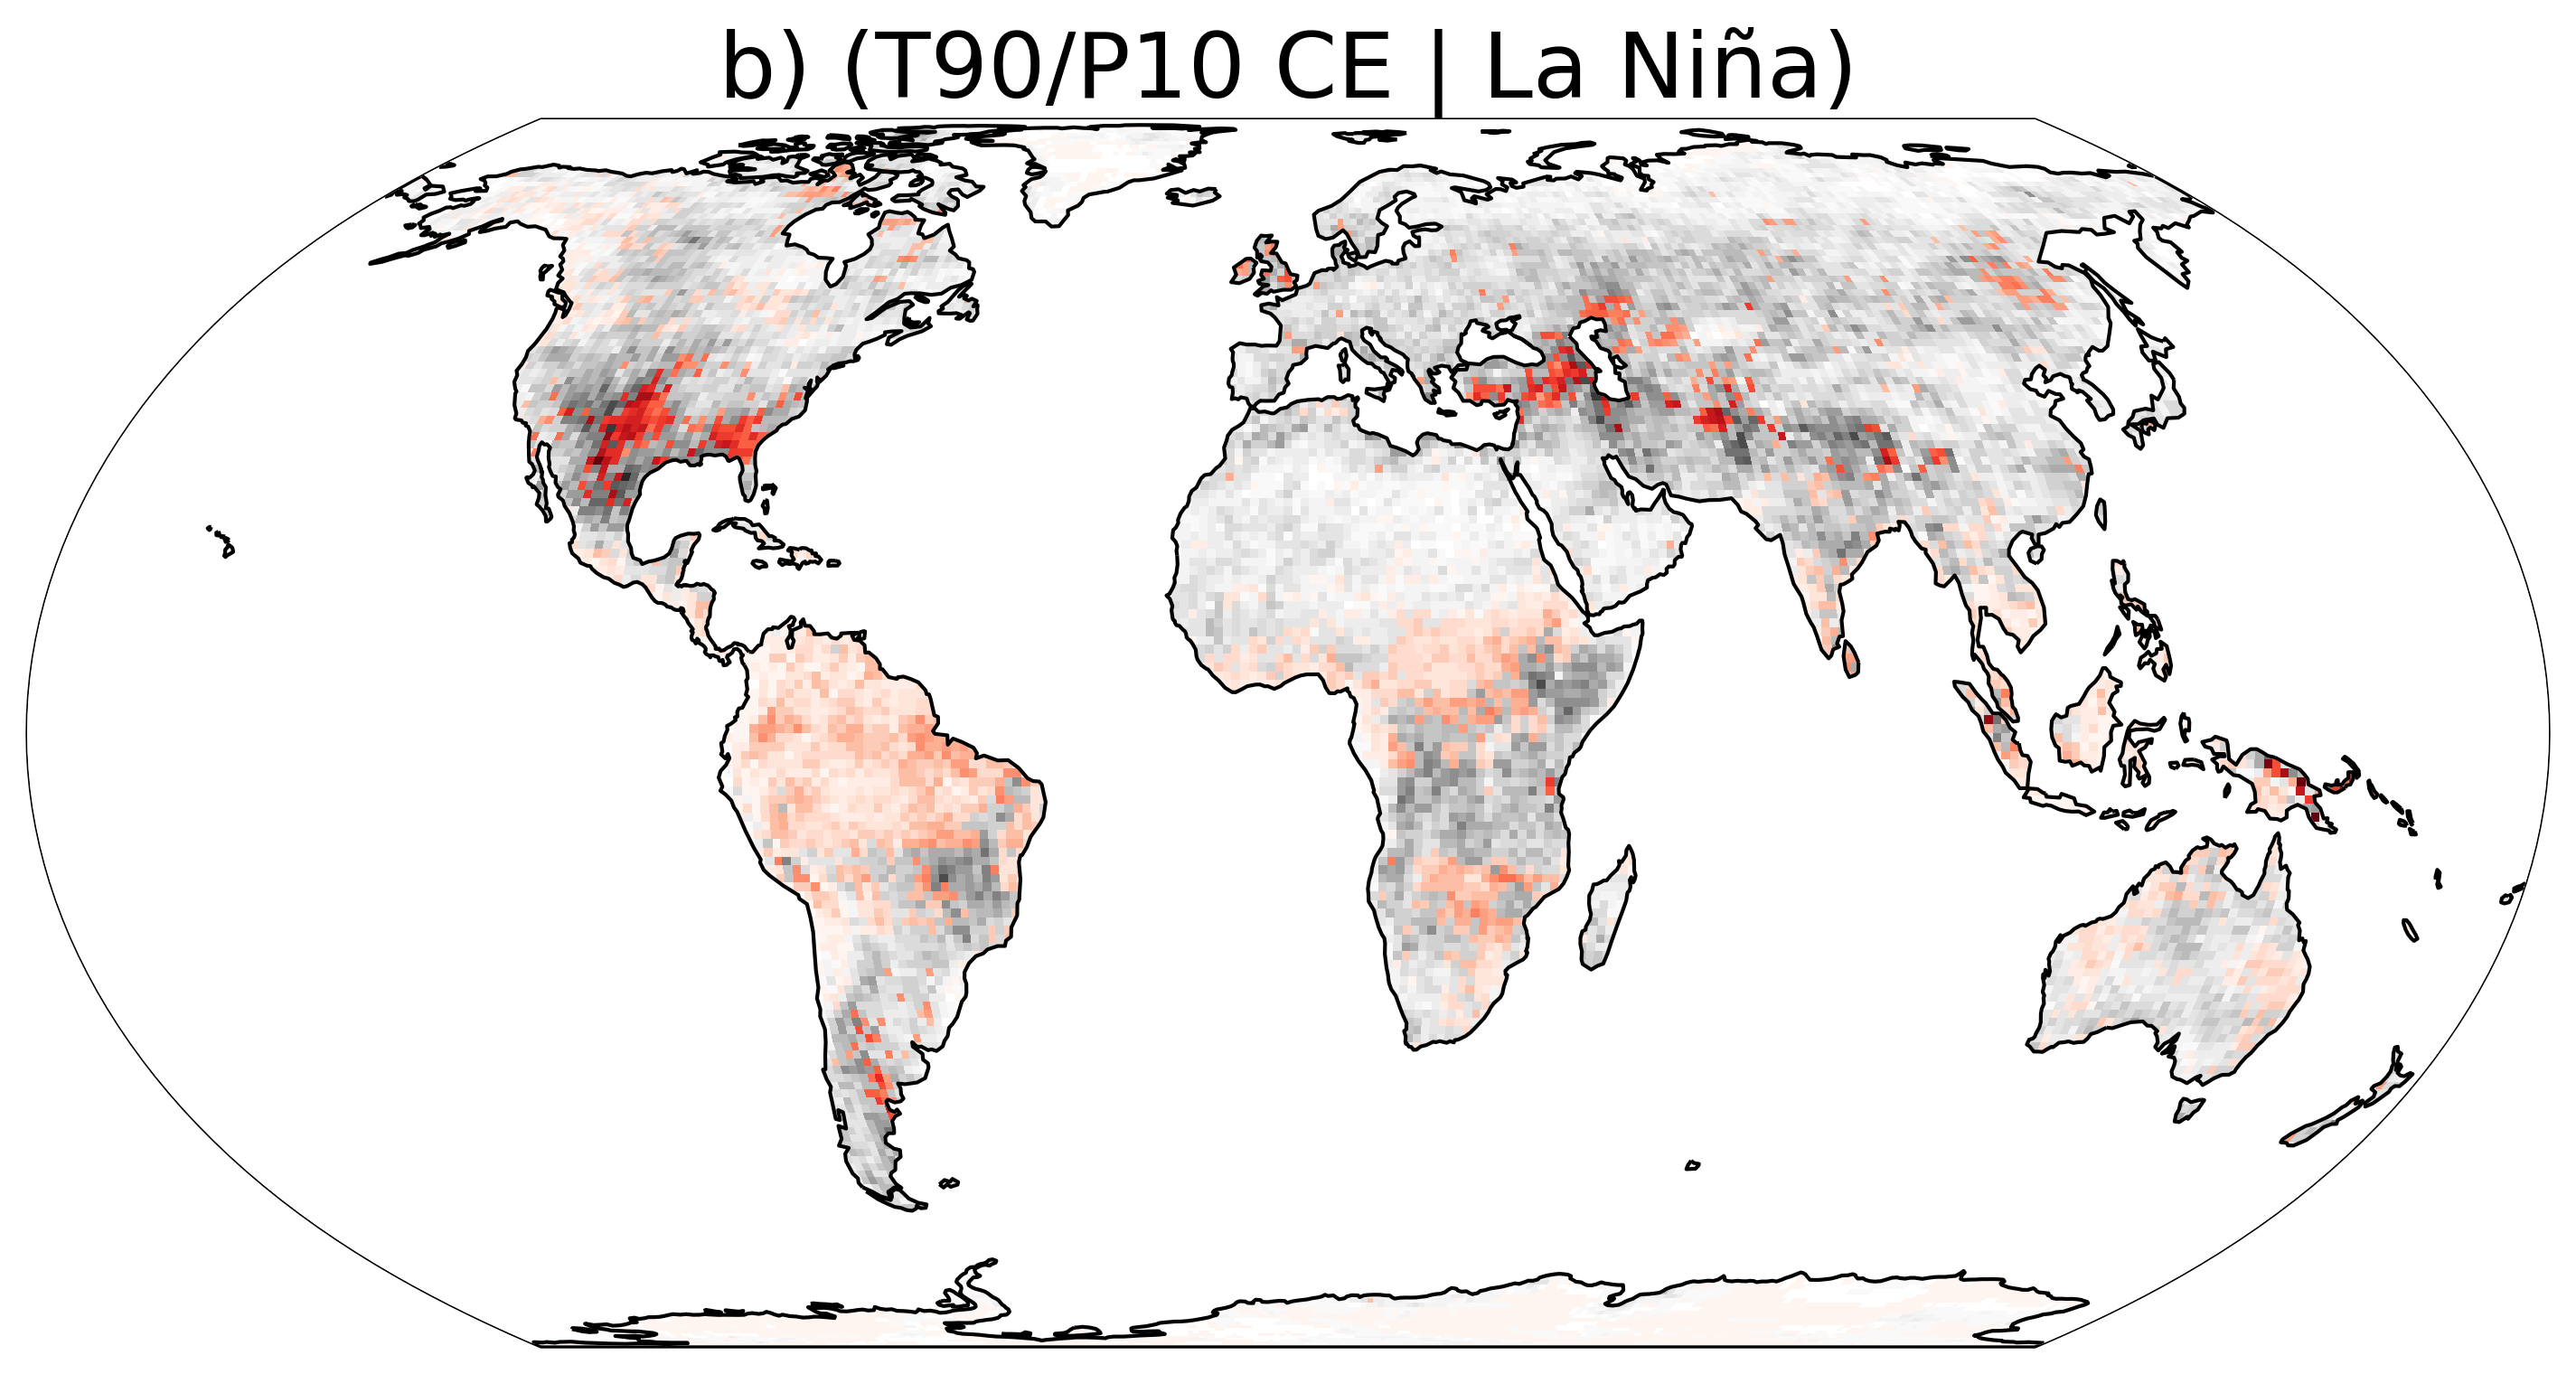

In [13]:
# Apply latitude bounds to exclude Antarctica
lat_bounds = -57

# Filter the xarray DataArray to exclude latitudes below the bound
#ces_given_enso_filtered = ces_given_enso.where(ces_given_enso['lat'] > lat_bounds, drop=True)

# Create a boolean mask for latitudes greater than lat_bounds
#lat_mask = ces_given_enso['lat'].values > lat_bounds

# Apply the mask to the chi_squared numpy array
#stipple_test_filtered = chi_squared[lat_mask, :]

# Ensure the stipple_test_filtered has the same shape as ces_given_enso_filtered
stipple_points = np.where(chi_squared <= 3.841, ces_given_enso, np.nan)

# Extract the filtered latitude and longitude values
lon = ces_given_enso['lon']
lat = ces_given_enso['lat']

# Plot the figure
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.EqualEarth())
plt.pcolormesh(lon, lat, ces_given_enso, cmap='Reds', transform=ccrs.PlateCarree(), vmin=0, vmax=8)

ax.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k', color='white')
ax.add_feature(cfeature.COASTLINE, zorder=101, edgecolor='black')

plt.title("b) (T90/P10 CE | La Niña)", size = 24)

plt.pcolormesh(lon, lat, stipple_points, transform=ccrs.PlateCarree(), cmap='Grays', vmin=0, vmax=8)
plt.show()


CE Given Two Modes

N = <xarray.DataArray (lat: 192, lon: 288)> Size: 442kB
array([[86, 86, 86, ..., 86, 86, 86],
       [86, 86, 86, ..., 86, 86, 86],
       [86, 86, 86, ..., 86, 86, 86],
       ...,
       [86, 86, 86, ..., 86, 86, 86],
       [86, 86, 86, ..., 86, 86, 86],
       [86, 86, 86, ..., 86, 86, 86]])
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    expver   int32 4B 1
m1 chunking done
m2 chunking done
matching done
<xarray.DataArray (lat: 192, lon: 288)> Size: 442kB
array([[251, 251, 251, ..., 251, 251, 251],
       [251, 251, 251, ..., 251, 251, 251],
       [251, 251, 251, ..., 251, 251, 251],
       ...,
       [251, 251, 251, ..., 251, 251, 251],
       [251, 251, 251, ..., 251, 251, 251],
       [251, 251, 251, ..., 251, 251, 251]])
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.

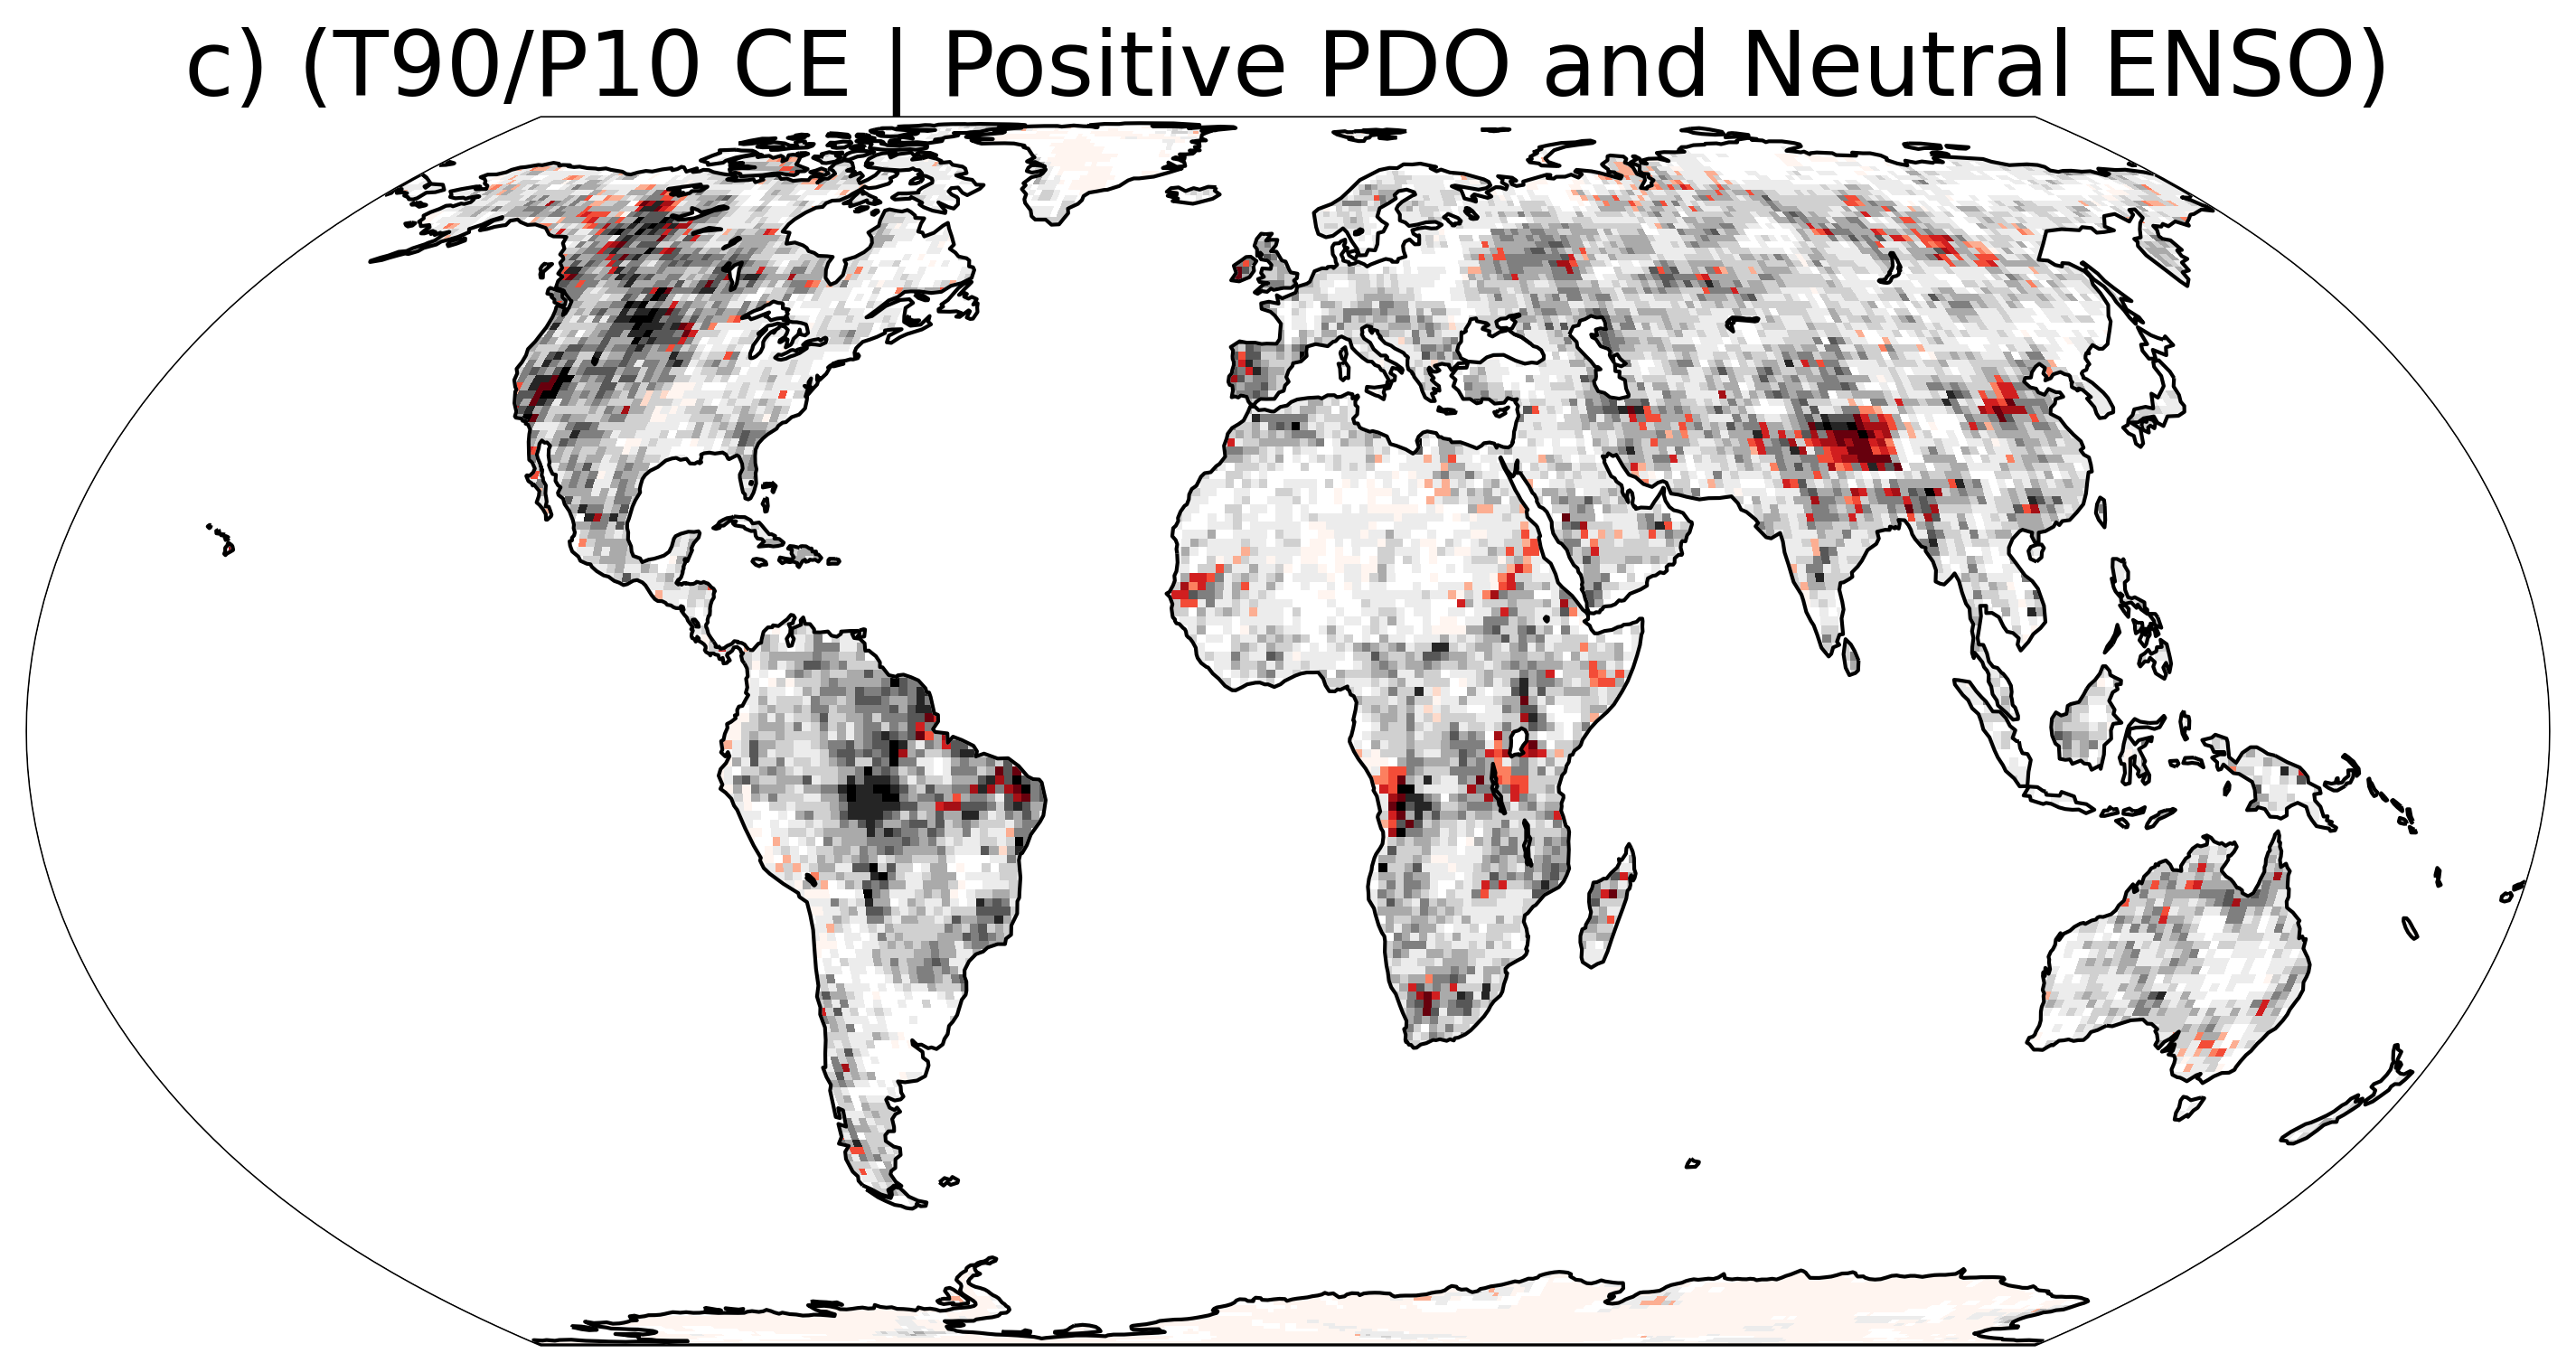

In [13]:
ces_given_mode_calc = ce_given_two_modes_prob(ce_binary, pdo_anoms_1950_2024, nino_34_anoms, nao_anoms_1950_2023, True, False)

#############################################################################

chi_squared_array = chi_squared_two_modes(ce_binary, pdo_anoms_1950_2024, nino_34_anoms, nao_anoms_1950_2023, 120, 1008, False)

##############################################################################

# Apply latitude bounds to exclude Antarctica
lat_bounds = -57

# Filter the xarray DataArray to exclude latitudes below the bound
#ces_given_mode_calc_filtered = ces_given_mode_calc.where(ces_given_mode_calc['lat'] > lat_bounds, drop=True)

# Create a boolean mask for latitudes greater than lat_bounds
#lat_mask = ces_given_mode_calc['lat'].values > lat_bounds

# Apply the mask to the stipple_test numpy array
#chi_squared_filtered = chi_squared_array[lat_mask, :]

# make sure chi_squared has the same shape as ces_given_mode_calc
stipple_points = np.where(chi_squared_array <= 3.841, ces_given_mode_calc, np.nan)

# Extract the filtered latitude and longitude values
lon = ces_given_mode_calc['lon']
lat = ces_given_mode_calc['lat']

# Plot the figure
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.EqualEarth())
plt.pcolormesh(lon, lat, ces_given_mode_calc, cmap='Reds', transform=ccrs.PlateCarree(), vmin=0, vmax=8)
#cbar = plt.colorbar(orientation = 'horizontal', pad = 0.01, fraction = 0.05, extend = 'max', shrink = 1.4, label = 'Conditional Frequency (%)')

ax.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k', color='white')
ax.add_feature(cfeature.COASTLINE, zorder=101, edgecolor='black')
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='white')

plt.title("c) (T90/P10 CE | Positive PDO and Neutral ENSO)", size = 24)

plt.pcolormesh(lon, lat, stipple_points, transform=ccrs.PlateCarree(), cmap='Grays', vmin=0, vmax=8)

plt.show()